In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from torch_geometric.utils import from_networkx, to_networkx


import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, Callback, TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger



from typing import Callable, Optional

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from utils.heterophilic import get_dataset, get_fixed_splits, WebKB, Actor
from project.sheaf_datamodule import SheafDataset_ForGraphs, SheafDataModule_ForGraphs
from project.sheaf_learner import coboundary_learner_on_graph_signal
from project.sheaf_diffusion import sheaf_diffusion
from project.sheaf_simultaneous_sparse import sheaf_gradient_flow
from project.sheaf_simultaneous_potential import sheaf_gradient_flow_potential

In [5]:
dataset = get_dataset('texas')


In [6]:
dataset = get_dataset('texas')
data = dataset[0]
data = get_fixed_splits(data, 'texas', 0)

In [7]:
graph = to_networkx(data)

In [8]:
mask = {'train_mask':data.train_mask, 
        'val_mask':data.val_mask, 
        'test_mask':data.test_mask
       }

In [9]:
#    def __init__(self, graph, Nv, dv, Ne, de, layers, input_dim, output_dim, channels, left_weights, right_weights, mask, use_act, augmented, add_lp, add_hp, dropout,input_dropout, learning_rate = 0.01):
#         def __init__(self, graph, Nv, dv, Ne, de, layers, input_dim, output_dim, channels, left_weights, right_weights, potential, mask, use_act, augmented, add_lp, add_hp, dropout, input_dropout, learning_rate = 0.01):

model_diffusion = sheaf_gradient_flow_potential(graph, 183, 3, graph.number_of_edges(), 3, 3, 1703,5, 4, True, True, 'radial', mask, True,True,True,True, 0.6,0.6, 0.0001)

In [10]:
#model_diffusion

In [11]:
wandb_logger_diffusion = WandbLogger(project="sheaf_learning_diffusion_with_coboundary_potential")

wandb: Currently logged in as: saepark. Use `wandb login --relogin` to force relogin


In [20]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=20, verbose=False)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/root/projects/temp_checkpoints",
    filename="test-sheafgradflow-{epoch:02d}-{val_loss:.2f}",
    save_top_k=4,
    mode="min",
)
class PrintCallbacks(Callback):
    def on_init_start(self, trainer):
        print("Starting to init trainer!")

    def on_init_end(self, trainer):
        print("Trainer is init now")

    def on_train_end(self, trainer, pl_module):
        print("Training ended")


In [13]:
sheaf_dm = SheafDataModule_ForGraphs(data, 60 , 1)

In [21]:
trainer = Trainer(accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=10),PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=wandb_logger_diffusion,auto_lr_find=True)

Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


In [15]:
lr_finder = trainer.tuner.lr_find(model_diffusion, sheaf_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /root/projects/sheaf-learn-project/notebooks/.lr_find_46e46170-18e4-418a-8f0c-8617eb6f7f33.ckpt


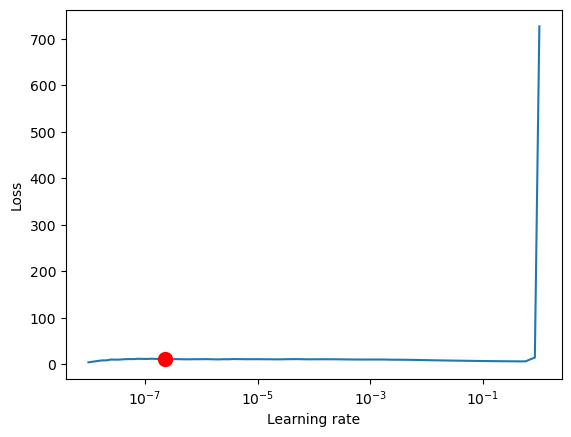

In [17]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [18]:
new_lr = lr_finder.suggestion()
model_diffusion.hparams.learning_rate = 0.01
model_diffusion.learning_rate = 0.01
#model_diffusion.hparams.learning_rate = new_lr
#model_diffusion.learning_rate = new_lr

In [22]:
trainer.fit(model_diffusion, sheaf_dm)

/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                       | Type          | Params
--------------------------------------------------------------
0  | coboundary_vec_out         | ParameterList | 5.0 K 
1  | coboundary_vec_in          | ParameterList | 5.0 K 
2  | graph_to_sheaf             | Linear        | 34.1 K
3  | graph_to_sheaf2            | Linear        | 420   
4  | self_energy_channel_mixing | Linear        | 20    
5  | self_energy_stalk_mixing   | Linear        | 30    
6  | diffusion_stalk_mixing     | Linear        | 30    
7  | diffusion_channel_mixing   | Linear        | 20    
8  | lin_left_weights           | ModuleList    | 75    
9  | lin_right_weights          | ModuleList    | 48    
10 | batch_norms  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


In [23]:
torch.diag(1.+5*torch.ones(3))

tensor([[6., 0., 0.],
        [0., 6., 0.],
        [0., 0., 6.]])

wandb: Network error (ReadTimeout), entering retry loop.


In [19]:
import torch
from torch_sparse import coalesce

In [23]:
index = torch.tensor([[1, 0, 1, 0, 2, 1],
                      [0, 1, 1, 1, 0, 0]])
value = torch.Tensor([1,2,3,4,5,6])

index, value = coalesce(index, value, m=3, n=2)

In [24]:
index

tensor([[0, 1, 1, 2],
        [1, 0, 1, 0]])

In [25]:
value

tensor([6., 7., 3., 5.])